(solph-linear)=

# Linear oemof-solph heat pump model

## Introduction

To implement a heat pump in a linear energy system optimization model, it is possible to precalculate COP factors for
every time step, when knowing the temperature values before running the optimization. To do that, assumptions have to be
made to determine the COP, since such data is typically not provided over a large range of temperature values, but for
single temperature specifications only.

The COP of the heat pump can be calculated from the ratio of total produced heat {math}`\dot Q_\text{prod}` to the total
required work {math}`\sum \dot W` in eq. {eq}`cop-heat-pump-general`. For a simple 4-component heat pump setup, the
definitions simplifies to a single heat output at the condenser and a single work input at the compressor eq.
{eq}`cop-heat-pump-simple`. We use the absolute value of the heat produced to obtain a positive COP value when following
a system oriented sign convention.

```{math}
    :label: cop-heat-pump-general
    \text{COP} = \frac{|\sum \dot Q_\text{prod}|}{\sum \dot W}
```

```{math}
    :label: cop-heat-pump-simple
    \text{COP} = \frac{|\dot Q_\text{prod}|}{\dot W}
```

Since we want to impose the COP on our energy system model, we need to find a adequate value for the use case 
implemented. One way of doing this, would be by calculating the Carnot COP {math}`\text{COP}_\text{c}`, which is the
thermodynamically best COP possible and adjusting its value with an efficiency factor {math}`\eta_\text{hp}`. For a
simplified approach, the Carnot COP can be obtained with eq. {eq}`carnot-cop-heat-pump`.

```{math}
    :label: carnot-cop-heat-pump
    \text{COP}_\text{c} = \frac{T_\text{max}}{T_\text{max} - T_\text{min}}
```

The efficiency factor is usually considered a constant value. With that, we can calculate the COP based on an ambient
temperature profile and the target heating temperature:

```{math}
    :label: cop-heat-pump-carnot-and-efficiency
    \text{COP} = \frac{T_\text{max}}{T_\text{max} - T_\text{min}} \cdot \eta_\text{hp}
```


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_temperature_data():
    """Returns temperature (in °C) over timestamp
    """
    # weather data from https://wetterstation.physik.rwth-aachen.de/datenbank.php
    df = pd.read_csv("../2023_Stundenstatistik.txt", delim_whitespace=True)
    df.index = (pd.to_datetime(
        [
            f"{year}-{month}-{day} {hour}:00:00"
            for year, month, day, hour in zip(df['#Jahr'], df['Monat'], df['Tag'], df['Stunde'])
        ]
    ))
    df = df[["T_Mid"]]
    df.rename(columns={"T_Mid": "Ambient temperature (°C)"}, inplace=True)

    return df


input_data = load_temperature_data().head(24*3)

# A crude demand model should be enough for us. Let the demand be 500 W per K below 15 °C.
input_data["Heat load (kW)"] = (0.5 * (15 - input_data["Ambient temperature (°C)"])).clip(lower=0)


## Real World Heat Pump

Now, we want to add an air-source heat-pump centered heat supply system.  Short online research for example yields:

* Rated heating output (kW) at operating point A7/W35: 9.1 kW
* Coefficient of performance ε (COP) A7/W35: 4.9

{cite}`viessmann2023`, Type A.16


## Carnot COP Method

From the datasheet we know, what the COP of the heat pump is for a specific set of temperatures at nominal load, i.e.

- an ambient temperature of 7 °C and
- heat production temperature of 35 °C.

However, we do not know, the COP at ambient temperature levels different from 7 °C. With the efficiency factor from
eq. {eq}`cop-heat-pump-carnot-and-efficiency` and the definition of the Carnot COP (eq. {eq}`carnot-cop-heat-pump`) we
can find the actual COP of the heat pump **under the assumption, that the efficiency factor is a constant value**.



In [12]:
datasheet_cop = 4.9
carnot_cop_7_35 = (35+273.15) / (35-7)
cpf_7_35 = datasheet_cop / carnot_cop_7_35

carnot_cop_2_40 = (40+273.15) / (40-2)
cpf_2_40 = datasheet_cop / carnot_cop_2_40

input_data["cpf COP 7 -> 35"] = cpf_7_35 * (35+273.15) / (35 - input_data["Ambient temperature (°C)"])
input_data["cpf COP 2 -> 40"] = cpf_2_40 * (40+273.15) / (40 - input_data["Ambient temperature (°C)"] + 5)

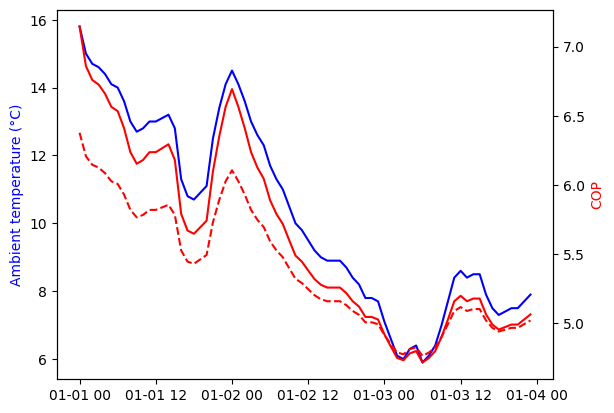

In [13]:
plt.plot(input_data["Ambient temperature (°C)"], "b-")
plt.ylabel("Ambient temperature (°C)").set_color("blue")

plt.twinx()

plt.plot(input_data["cpf COP 7 -> 35"], "r-")
plt.plot(input_data["cpf COP 2 -> 40"], "r--")
plt.ylabel("COP").set_color("red")

plt.show()

In [14]:
from myst_nb import glue
from utilities import TTD_HEAT_EXCHANGERS, HEATING_SYSTEM_FEED_TEMP, AMBIENT_TEMP_NOMINAL
glue("heat-exchanger-ttd", TTD_HEAT_EXCHANGERS, display=False)
glue("evaporation-temperature", AMBIENT_TEMP_NOMINAL - TTD_HEAT_EXCHANGERS, display=False)
glue("condensation-temperature", HEATING_SYSTEM_FEED_TEMP + TTD_HEAT_EXCHANGERS, display=False)

Howver, note that we have to use the maximum and minimum temperature of the process when working with the Carnot COP.
The figure {numref}`heat-pump-black-box-vs-process` shows two different representations of the heat pump: One as a black
box and one as component based process. In the black box process, we only see the temperature levels of the air and the
water system. In the actual heat pump heat is transferred from the air to the working fluid and from the working fluid
to the water system. This cannot happen without thermodynamic losses, meaing that the temperature of the working fluid
must be lower than the air temperature when evaporating and the temperature must be higher when condensing and providing
heat to the water system. This however changes our reference temperature levels for the Carnot COP, as the maximum and
minimum temperatures of the process are not the air and water temperatures but refer to the working fluid.

```{figure} /figures/heat_pump_blackbox_comparison.svg
---
alt: Heat pump black box compared to actual heat pump process
name: heat-pump-black-box-vs-process
---
Heat pump black box compared to actual heat pump process
```

Since we do not have any internal data of the heat pump, we have to make an assumption to determine the Carnot COP in
this way. For both heat exchangers we assume a temperature difference of {glue:text}`heat-exchanger-ttd` K, therefore
an condensation temperature of {glue:text}`condensation-temperature` °C and an evaporation temperature of
{glue:text}`evaporation-temperature` °C. This changes our Carnot COP, and given, that we want to have the same COP as in
our first assessment, the efficiency factor.

- Hier dann der Vergleich der beiden Varianten mit kurzer Erklärung, warum es bei 7/35 bzw. 2/40 passt, darüber und
darunter aber Abweichungen gibt.

In [ ]:
hp_thermal_power = 9.1  # kW
cop = input_data["constant efficiency COP"][:-1]
demand = input_data["Heat load (kW)"][:-1]

In [17]:
import oemof.solph as solph

cop = input_data["cpf COP 7 -> 35"][:-1]
demand = input_data["Heat load (kW)"][:-1]

es = solph.EnergySystem(timeindex=input_data.index, infer_last_interval=False)

b_electricity = solph.Bus(label="electricity")
b_heat_35C = solph.Bus(label="heat 35C")
es.add(b_electricity, b_heat_35C)

electricity_grid = solph.components.Source(
    label="electricity grid",
    outputs={b_electricity: solph.Flow(variable_costs=0.4)},  # €/kWh
)

heat_demand = solph.components.Sink(
    label="heat demand",
    inputs={b_heat_35C: solph.Flow(nominal_value=1, fix=demand)},  # kW
)
es.add(electricity_grid, heat_demand)


heat_pump = solph.components.Transformer(
    label="heat pump",
    inputs={b_electricity: solph.Flow()},
    outputs={b_heat_35C: solph.Flow(nominal_value=hp_thermal_power)},
    conversion_factors={
        b_electricity: 1 / cop,
        b_heat_35C: 1,
    },
)

es.add(heat_pump)

heating_rod = solph.components.Transformer(
    label="heating rod",
    inputs={b_electricity: solph.Flow()},
    outputs={b_heat_35C: solph.Flow()},
)

es.add(heating_rod)

thermal_storage = solph.components.GenericStorage(
    label='thermal_storage',
    inputs={b_heat_35C: solph.Flow()},
    outputs={b_heat_35C: solph.Flow()},
    loss_rate=0.02,
    nominal_storage_capacity=8.7,  # Assume 5 k of spread and 1.5 m³ volume 
)

es.add(thermal_storage)

model = solph.Model(energysystem=es)

model.solve()

results = solph.processing.results(model)

Electricity demand: 32.9 kWh


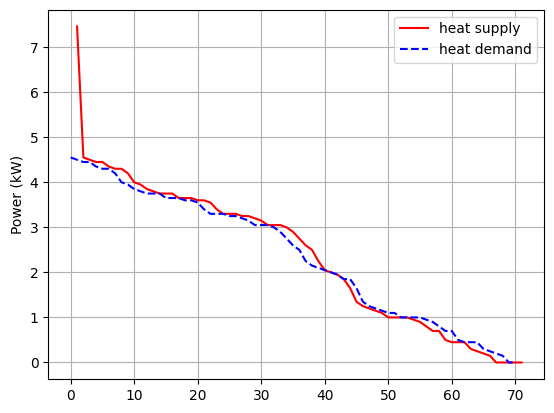

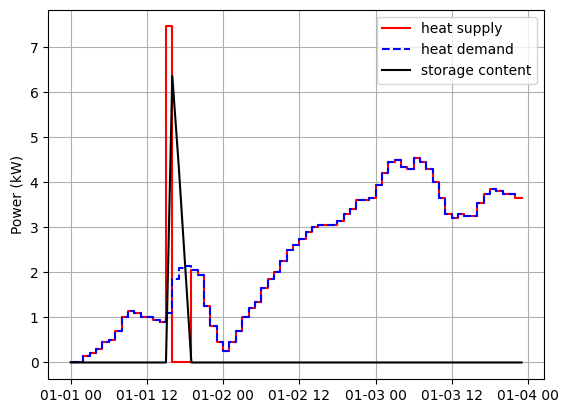

In [20]:
heat_supply = results[(heat_pump, b_heat_35C)]["sequences"]["flow"]
storage_content = results[(thermal_storage, None)]["sequences"]["storage_content"]

plt.plot(np.sort(heat_supply)[::-1], "r-", label="heat supply")
plt.plot(np.sort(demand)[::-1], "b--", label="heat demand")
plt.ylabel("Power (kW)")
plt.grid()
plt.legend()

plt.figure()
plt.plot(heat_supply, "r-", label="heat supply", drawstyle="steps-post")
plt.plot(demand, "b--", label="heat demand", drawstyle="steps-post")
plt.plot(storage_content, "k-", label="storage content")
plt.ylabel("Power (kW)")
plt.grid()
plt.legend()

electricity_consumption = float(results[(electricity_grid, b_electricity)]["sequences"].sum())
print(f"Electricity demand: {electricity_consumption:.1f} kWh")
